In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/quora_duplicate_questions_detection/

/content/drive/.shortcut-targets-by-id/1NfDfMFFEa6jbcf5EQ_tVWbvhytT96tlt/quora_duplicate_questions_detection


In [3]:
!ls

 bert			       lstm_feature_test1.ipynb
 bilstm_nn_test1.ipynb	       lstm_test1.ipynb
 bilstm_nn_test2.ipynb	       model.png
 classifier.py		       models
 cnn_features_test1.ipynb      models4.ipynb
 cnn_test1.ipynb	       models5.ipynb
'Copy of deep_nn.ipynb'        model_tfidf.ipynb
'Copy of nlp_features.ipynb'   nlp_features.ipynb
 data			       nn_plot
 deep_nn.ipynb		       non_nlp_features.ipynb
 deep_nn_test1.ipynb	       predictions
 deep_nn_test2.ipynb	       __pycache__
 deep_nn_test3.ipynb	       tfidf_model.ipynb
 feature_engineering.ipynb     Untitled.ipynb
 graphs			       utils.py
 gru_test1.ipynb	       word2vec_features.ipynb
 __init__.py


In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout
from keras.layers.core import Lambda
from keras.layers.merge import concatenate, add, multiply
from keras.models import Model, Sequential
from keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.noise import GaussianNoise
from keras import backend as K
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
np.random.seed(0)
WNL = WordNetLemmatizer()
STOP_WORDS = set(stopwords.words('english'))
MAX_SEQUENCE_LENGTH = 30
MIN_WORD_OCCURRENCE = 100
REPLACE_WORD = "rare"
EMBEDDING_DIM = 300
NUM_FOLDS = 10
BATCH_SIZE = 256
EMBEDDING_FILE = "data/glove.840B.300d.txt"

In [6]:
def cutter(word):
    if len(word) < 4:
        return word
    return WNL.lemmatize(WNL.lemmatize(word, "n"), "v")

In [7]:
def preprocess(string):
    string = string.lower().replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'") \
        .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not") \
        .replace("n't", " not").replace("what's", "what is").replace("it's", "it is") \
        .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are") \
        .replace("he's", "he is").replace("she's", "she is").replace("'s", " own") \
        .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ") \
        .replace("€", " euro ").replace("'ll", " will").replace("=", " equal ").replace("+", " plus ")
    string = re.sub('[“”\(\'…\)\!\^\"\.;:,\-\?？\{\}\[\]\\/\*@]', ' ', string)
    string = re.sub(r"([0-9]+)000000", r"\1m", string)
    string = re.sub(r"([0-9]+)000", r"\1k", string)
    string = ' '.join([cutter(w) for w in string.split()])
    return string

In [8]:
def get_embedding():
    embeddings_index = {}
    f = open(EMBEDDING_FILE, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        if len(values) == EMBEDDING_DIM + 1 and word in top_words:
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    f.close()
    return embeddings_index

In [9]:
def is_numeric(s):
    return any(i.isdigit() for i in s)

In [10]:
def prepare(q):
    new_q = []
    surplus_q = []
    numbers_q = []
    new_rare = True
    for w in q.split()[::-1]:
        if w in top_words:
            new_q = [w] + new_q
            new_rare = True
        elif w not in STOP_WORDS:
            if new_rare:
                new_q = ["rare"] + new_q
                new_rare = False
            if is_numeric(w):
                numbers_q = [w] + numbers_q
            else:
                surplus_q = [w] + surplus_q
        else:
            new_rare = True
        if len(new_q) == MAX_SEQUENCE_LENGTH:
            break
    new_q = " ".join(new_q)
    return new_q, set(surplus_q), set(numbers_q)

In [11]:
def extract_features(df):
    q1s = np.array([""] * len(df), dtype=object)
    q2s = np.array([""] * len(df), dtype=object)
    features = np.zeros((len(df), 4))

    for i, (q1, q2) in enumerate(list(zip(df["question1"], df["question2"]))):
        q1s[i], surplus1, numbers1 = prepare(q1)
        q2s[i], surplus2, numbers2 = prepare(q2)
        features[i, 0] = len(surplus1.intersection(surplus2))
        features[i, 1] = len(surplus1.union(surplus2))
        features[i, 2] = len(numbers1.intersection(numbers2))
        features[i, 3] = len(numbers1.union(numbers2))

    return q1s, q2s, features

In [12]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [13]:
train["question1"] = train["question1"].fillna("").apply(preprocess)
train["question2"] = train["question2"].fillna("").apply(preprocess)

In [14]:
print("Creating the vocabulary of words occurred more than", MIN_WORD_OCCURRENCE)
all_questions = pd.Series(train["question1"].tolist() + train["question2"].tolist()).unique()
vectorizer = CountVectorizer(lowercase=False, token_pattern="\S+", min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(all_questions)
top_words = set(vectorizer.vocabulary_.keys())
top_words.add(REPLACE_WORD)

Creating the vocabulary of words occurred more than 100


In [15]:
embeddings_index = get_embedding()
print("Words are not found in the embedding:", top_words - embeddings_index.keys())
top_words = embeddings_index.keys()

Words are not found in the embedding: {'quorans', 'redmi', 'kvpy', 'paytm', '\\frac', 'brexit', 'c#', 'iisc', 'oneplus', 'demonetisation', '\\sqrt'}


In [16]:
print("Train questions are being prepared for LSTM...")
q1s_train, q2s_train, train_q_features = extract_features(train)

Train questions are being prepared for LSTM...


In [17]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(np.append(q1s_train, q2s_train))
word_index = tokenizer.word_index

In [18]:
data_1 = pad_sequences(tokenizer.texts_to_sequences(q1s_train), maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(tokenizer.texts_to_sequences(q2s_train), maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(train["is_duplicate"])

In [19]:
nb_words = len(word_index) + 1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

In [20]:
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
print("Train features are being merged with NLP and Non-NLP features...")
train_nlp_features = pd.read_csv("data/nlp_features_train.csv")
train_non_nlp_features = pd.read_csv("data/non_nlp_features_train.csv")
features_train = np.hstack((train_q_features, train_nlp_features, train_non_nlp_features))

Train features are being merged with NLP and Non-NLP features...


In [22]:
print("Same steps are being applied for test...")
test["question1"] = test["question1"].fillna("").apply(preprocess)
test["question2"] = test["question2"].fillna("").apply(preprocess)

q1s_test, q2s_test, test_q_features = extract_features(test)

test_data_1 = pad_sequences(tokenizer.texts_to_sequences(q1s_test), maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(tokenizer.texts_to_sequences(q2s_test), maxlen=MAX_SEQUENCE_LENGTH)

test_nlp_features = pd.read_csv("data/nlp_features_test.csv")
test_non_nlp_features = pd.read_csv("data/non_nlp_features_test.csv")
features_test = np.hstack((test_q_features, test_nlp_features, test_non_nlp_features))

Same steps are being applied for test...


In [23]:
stratified_kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True)
model_count = 0

MODEL: 0
Epoch 1/25
1422/1422 [==============================] - 73s 44ms/step - loss: 0.2844 - accuracy: 0.8661 - val_loss: 0.2570 - val_accuracy: 0.8802
Epoch 2/25
1422/1422 [==============================] - 58s 41ms/step - loss: 0.2567 - accuracy: 0.8803 - val_loss: 0.2534 - val_accuracy: 0.8826
Epoch 3/25
1422/1422 [==============================] - 58s 41ms/step - loss: 0.2499 - accuracy: 0.8842 - val_loss: 0.2420 - val_accuracy: 0.8890
Epoch 4/25
1422/1422 [==============================] - 56s 39ms/step - loss: 0.2442 - accuracy: 0.8874 - val_loss: 0.2461 - val_accuracy: 0.8879
Epoch 5/25
1422/1422 [==============================] - 55s 39ms/step - loss: 0.2399 - accuracy: 0.8904 - val_loss: 0.2455 - val_accuracy: 0.8872
Epoch 6/25
1422/1422 [==============================] - 54s 38ms/step - loss: 0.2363 - accuracy: 0.8921 - val_loss: 0.2565 - val_accuracy: 0.8799
Epoch 7/25
1422/1422 [==============================] - 54s 38ms/step - loss: 0.2333 - accuracy: 0.8938 - val_loss:

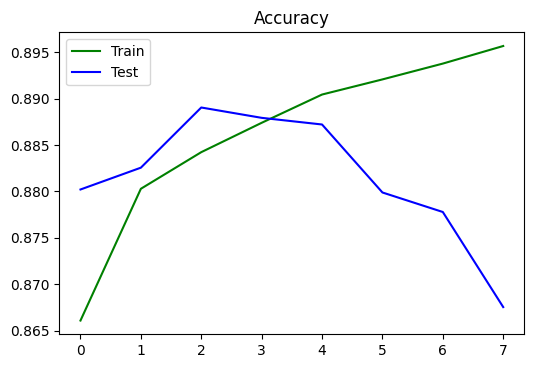

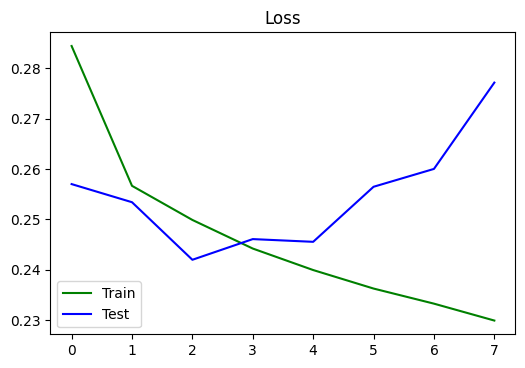

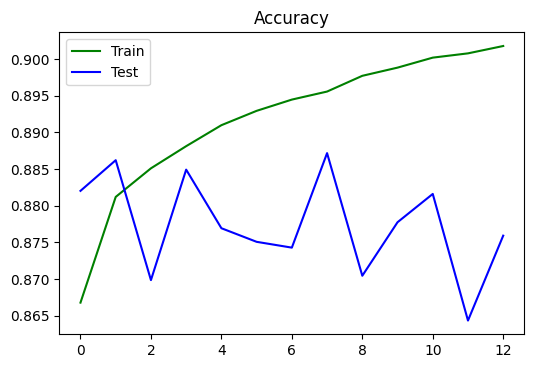

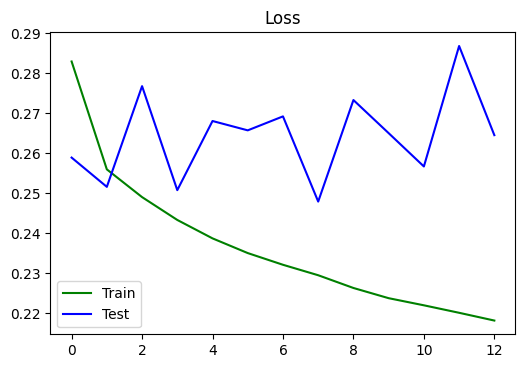

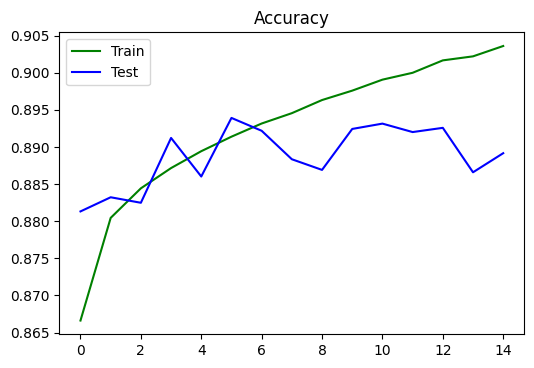

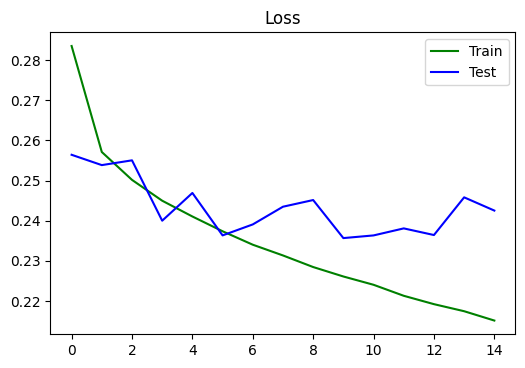

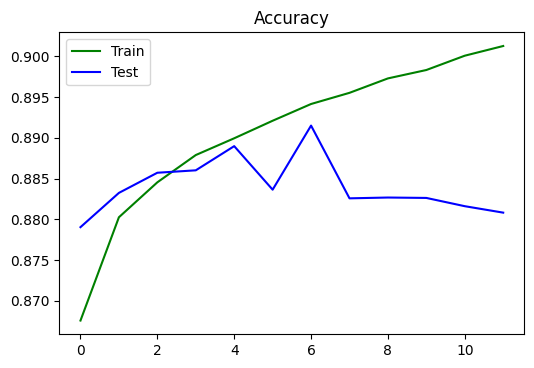

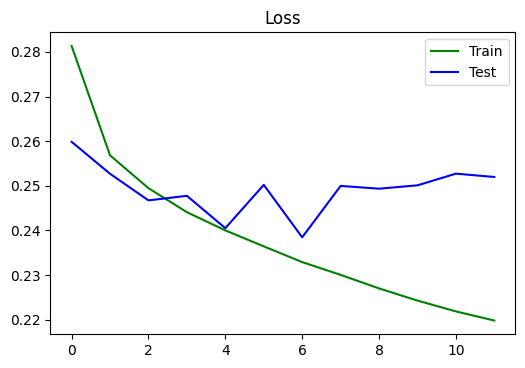

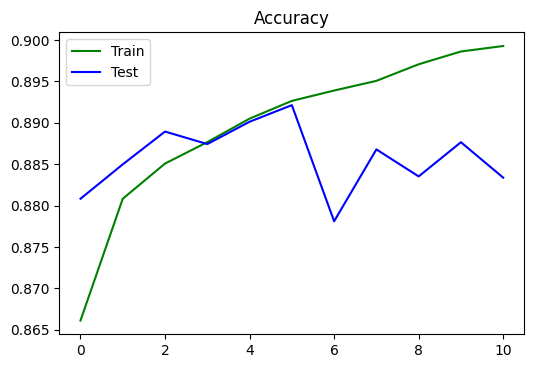

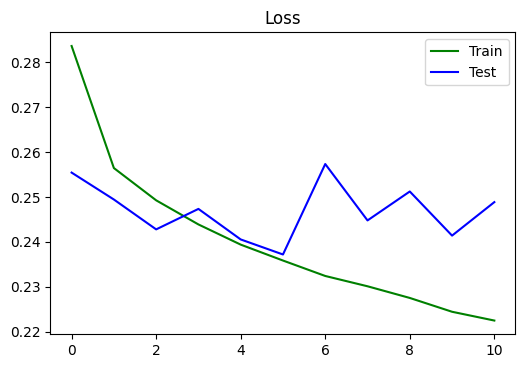

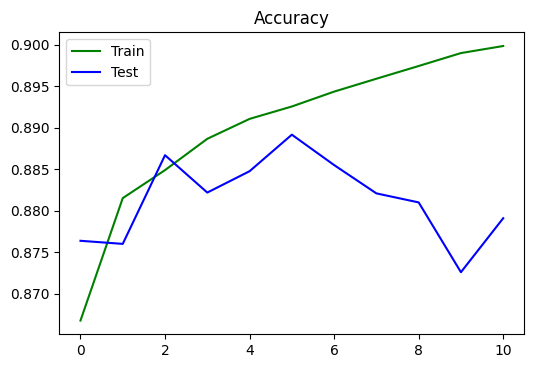

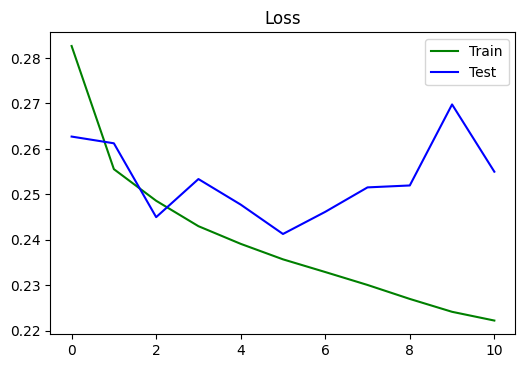

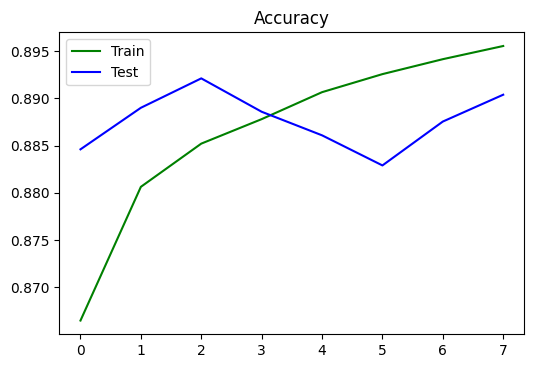

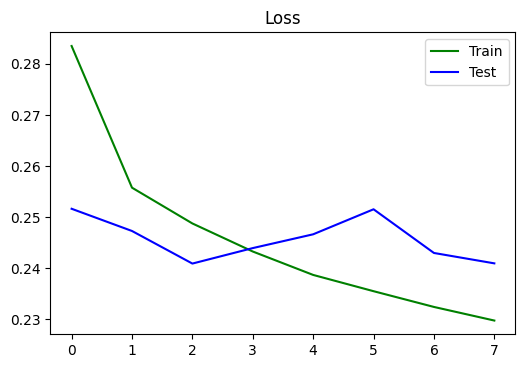

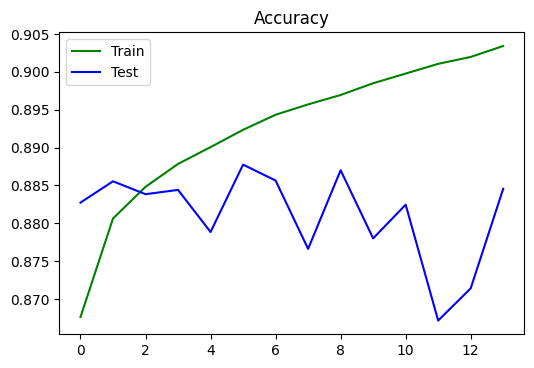

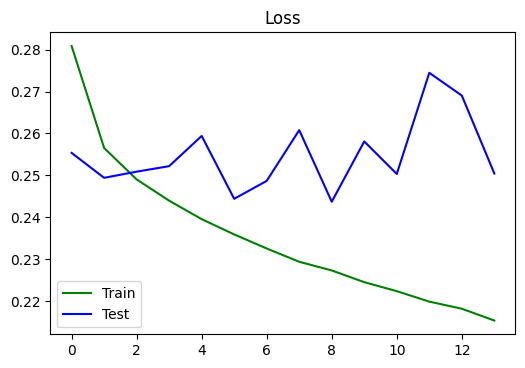

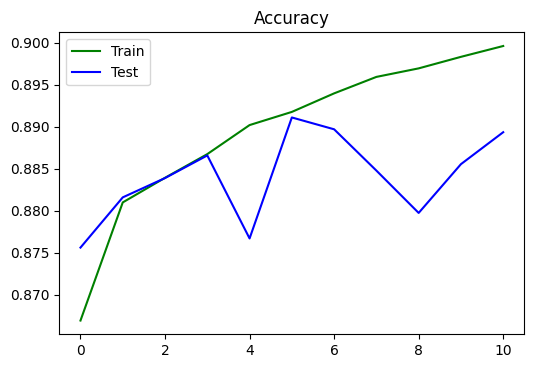

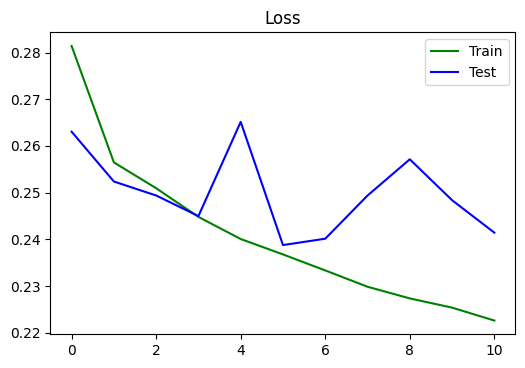

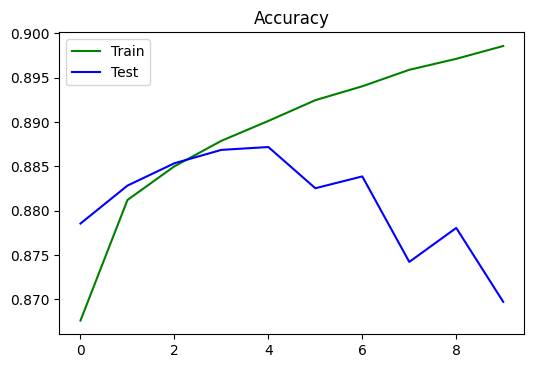

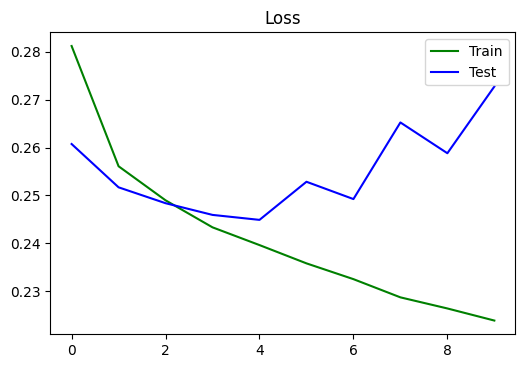

In [24]:
for idx_train, idx_val in stratified_kf.split(train["is_duplicate"], train["is_duplicate"]):
    print("MODEL:", model_count)
    data_1_train = data_1[idx_train]
    data_2_train = data_2[idx_train]
    labels_train = labels[idx_train]
    f_train = features_train[idx_train]

    data_1_val = data_1[idx_val]
    data_2_val = data_2[idx_val]
    labels_val = labels[idx_val]
    f_val = features_train[idx_val]

    embedding_layer = Embedding(nb_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    lstm_layer = Sequential()
    # Adding Embedding layer
    lstm_layer.add(embedding_layer)          

    # Adding 2 Lstm layers
    lstm_layer.add(LSTM(32, return_sequences=True))
    lstm_layer.add(Dropout(0.2))

    lstm_layer.add(LSTM(64, return_sequences=False))
    lstm_layer.add(Dropout(0.2))


    # Adding Dense layer
    lstm_layer.add(Dense(128,activation="linear"))
    lstm_layer.add(Dropout(0.3))

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
    x1 = lstm_layer(sequence_1_input)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
    y1 = lstm_layer(sequence_2_input)

    features_input = Input(shape=(f_train.shape[1],), dtype="float32")
    features_dense = BatchNormalization()(features_input)
    features_dense = Dense(200, activation="relu")(features_dense)
    features_dense = Dropout(0.2)(features_dense)

    lamda_function=Lambda(lambda tensor:K.abs(tensor[0]-tensor[1]),name="Absolute_distance")
    abs_distance_vector=lamda_function([x1,y1])

    lamda_function2=Lambda(lambda tensor:K.abs(tensor[0]*tensor[1]),name="Hamadard_multiplication") #abs() returns absolute value
    hamadard_vector=lamda_function2([x1,y1])

    merged = add([abs_distance_vector, hamadard_vector])
    merged = concatenate([merged, features_dense])
    merged = BatchNormalization()(merged)

    out = Dense(1, activation="sigmoid")(merged)

    model = Model(inputs=[sequence_1_input, sequence_2_input, features_input], outputs=out)
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
    plot_model(model, to_file='nn_plot/lstm_feature.png', show_shapes=True, expand_nested=True)

    early_stopping = EarlyStopping(monitor="val_loss", patience=5)
    best_model_path = "models/lstm_feature/best_model" + str(model_count) + ".h5"
    model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)

    model_history = model.fit([data_1_train, data_2_train, f_train], labels_train, 
                     batch_size=BATCH_SIZE, epochs=25, shuffle=True,
                     validation_data=([data_1_val, data_2_val, f_val], labels_val),
                     callbacks=[early_stopping, model_checkpoint], verbose=1)

    model.load_weights(best_model_path)
    print(model_count, "validation loss:", min(model_history.history["val_loss"]))
    print(model_count, "validation accuracy:", max(model_history.history["val_accuracy"]))
    # Accuracy Graph
    fig = plt.figure(dpi = 100)
    plt.title("Accuracy")
    plt.plot(model_history.history["accuracy"], color = "g", label = "Train")
    plt.plot(model_history.history["val_accuracy"], color = "b", label = "Test")
    plt.legend(loc = "best")
    plt.savefig("graphs/lstm_feature/accuracyLSTM" + str(model_count) + ".png")
    # Loss Graph
    fig = plt.figure(dpi = 100)
    plt.title("Loss")
    plt.plot(model_history.history["loss"], color = "g", label = "Train")
    plt.plot(model_history.history["val_loss"], color = "b", label = "Test")
    plt.legend(loc = "best")
    plt.savefig("graphs/lstm_feature/lossLSTM" + str(model_count) + ".png")
    preds = model.predict([test_data_1, test_data_2, features_test], batch_size=BATCH_SIZE, verbose=1)

    submission = pd.DataFrame({"test_id": test["test_id"], "is_duplicate": preds.ravel()})
    submission.to_csv("predictions/lstm_feature/preds" + str(model_count) + ".csv", index=False)

    model_count += 1